# In-class excercise working with single-subject multi-session fMRI data

In [71]:
import numpy as np
from numpy import pi
from scipy.stats import f as spf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mat73
import nibabel as nib
from math import isclose
from astropy.stats import circcorrcoef
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from copy import deepcopy

## 01. Load data - visualize brain slices and single-voxel's activity

<div class="alert alert-success"> <b>*** Tasks *** </b><br>
    <b>(a). Unpack dimensions of the fMRI data into x, y, z and t respectively.  </b><br>
    <b>(b). Plot the raw signal intensity over time for any select voxel. </b><br>
    <b>(c). Visualize horizontal slices of the brain. </b>

</div>

In [5]:
# Load file
file_name = 'DO_05_REG_MC_DET_001.nii.gz'
nifti = nib.load(file_name)
data = nifti.dataobj

In [22]:
# (a). Unpack dimensions 

# —————————————————————————— fill in ——————————————————————————

In [23]:
# (b). Plot signal time series at select voxel 

# —————————————————————————— fill in ——————————————————————————

In [24]:
# (c). Plot a series of horizontal brain slices at different depths 

# —————————————————————————— fill in ——————————————————————————

## 02. Use ANOVA to subset voxels that are highly selective to spatial features


<div class="alert alert-success"> <b>*** Tasks *** </b><br>
    <b>(a). Change the number of bins used to group the stimuli together when performing the one-way ANOVA test on voxels.  </b><br>
    <b>(b). Plot the p-value distribution of of all tested voxels. Calculate the percentage of voxels that are spatially selective according to the model. </b><br>
</div>

#### Define the ANOVA function

In [6]:
# Credits to John Serences who wrote and adapted this to our data
#------------------------------------------------        
#------------------------------------------------
# one-way ANOVA function...
# writing code from scratch for anova just so that 
# its easier to flexibly deal with different numbers
# of feature bins and its a bit faster and no looping
# over voxels...
# note: port this to a .py file and import for use
# to make things cleaner...
#------------------------------------------------
#------------------------------------------------ 
def my_anova1(tri_avg_data, feat_labels, feat_span, num_feat_bins):

    #------------------------------------------------
    # quick size check - make sure each trial has a 
    # feature label (note - this siez check is redundant
    # with earlier size check outside of this function, but
    # including here in case we port this to a .py file)
    #------------------------------------------------
    if tri_avg_data.shape[0] != feat_labels.shape[0]:
        
        raise ValueError(f'Number of trials does not match number of stim features in my_anova1 for Subject {sub}')
    
    #------------------------------------------------
    # sort into bins before doing the one-way ANOVA
    # this should work for any circular feature space
    # provided the span of the space is correct (e.g. 180 or 360)
    #------------------------------------------------
    feat_bin = np.digitize(feat_labels, np.arange(0, feat_span, feat_span / num_feat_bins)) - 1

    #------------------------------------------------
    # now do the ANOVA calculations
    #------------------------------------------------

    # compute overall mean in each voxel
    over_m = np.mean(tri_avg_data, axis = 0)

    # compute total sum of squares
    ss_total = np.sum((tri_avg_data - np.repeat(np.expand_dims(over_m, axis = 1).T, tri_avg_data.shape[0], axis = 0)) ** 2, axis = 0)

    # compute mean and residual ss and explained ss for each group
    group_m = np.zeros( ( num_feat_bins, tri_avg_data.shape[1] ) )
    rss = np.zeros( ( num_feat_bins, tri_avg_data.shape[1] ) )
    #ess = np.zeros( ( feat_bins, tri_avg_data.shape[1] ) )

    for i in range(num_feat_bins): 
        
        # overall mean for this condition
        group_m[i,:] = np.mean(tri_avg_data[feat_bin == i,:], axis=0)

        # compute residual sum of squares for curent group
        rss[i,:] = np.sum( (tri_avg_data[feat_bin==i,:] - np.repeat(np.expand_dims(group_m[i,:], axis = 1).T, np.sum(feat_bin == i), axis = 0) ) ** 2, axis = 0)

        # compute explained ss
        #ess[i,:] = np.sum( np.repeat( np.expand_dims((over_m - group_m[i,:]) ** 2, axis = 1).T, np.sum(ori_bin == i), axis = 0 ), axis = 0)

    # compute total rss
    rss_total = np.sum(rss, axis = 0)

    # compute total ess
    ess_total = ss_total - rss_total #np.sum(ess, axis = 0)

    # residual degrees of freedom
    rss_df = tri_avg_data.shape[0] - num_feat_bins

    # residual mean square
    r_ms = rss_total / rss_df

    # explained degrees of freedom
    exp_df = num_feat_bins - 1

    # mean square explained
    exp_ms = ess_total / exp_df

    # f value and p-value
    f = exp_ms / r_ms
    p = spf.sf(f, exp_df, rss_df)

    # return f-values p-values
    return  f, p


#### Run ANOVA and threshold to get visually selective voxels

In [26]:
# Load an unpack localizer data
data = np.load('DO_localizer.npz',allow_pickle=True)
tri_avg_data = data['VoxDat'][()] # for each roi, this a matrix of [number of trials x number of voxels]
feat_labels = data['feat_labels'] # stimulus feature - location on screen in terms of polar angle 
roi_names = tri_avg_data.keys() # list of roi names

In [27]:
# (a). Run ANOVA using different values of "num_feat_bins" (hint: you can also systematically step through
#      a select set of "num_feat_bins" to find the optimal value which yields the largest number of 
#      statistically significant voxels)

# —————————————————————————— change values ——————————————————————————
num_feat_bins = 24 # how many bins to divide up continuous feature values into
# ———————————————————————————————————————————————————————————————————

feat_span = 360 # span of the feature space
p_vals = {}
for roi in roi_names:
    _, p_vals[roi] = my_anova1(tri_avg_data[roi], feat_labels, feat_span, num_feat_bins)

In [25]:
# (b). Plot the distribution of p-values for all voxels within select ROI, then calculate the proportion
#      of voxels that are location selective according to a threshold of p=0.05

# —————————————————————————— fill in ——————————————————————————

## 03. Use a cross-validated multi-output linear regression model to predict feature location based on voxel activity

<div class="alert alert-success"> <b>*** Tasks *** </b><br>
<b>(a). Perform K-fold cross validation using a two-output linear regression model. Evaluate model performance of predicting feature location on held out test dataset. </b><br>
    <b>(b). Bonus: try adding regularization (ridge or lasso) to the model. How does the strength of regularization relate to model performance? </b><br>
<br><i>Hints: You can use sklearn's LinearRegression (no regularization), Ridge or BayesianRidge (with regularization) function to perform model fitting and prediction. You can also use sklearn's RegressorChain to perform a multi-output regression without having to run two separate models for the X- and Y- cartesian locations respectively.</i>
</div>

#### Definition of circular correlation coefficient

In [37]:
def circ_corr(x, y):

    '''
    calculate correlation coefficient between two circular variables
    using fisher & lee circular correlation formula 
    x, y are both in radians [0.2pi]
    '''

    xu = x.copy()
    yu = y.copy()

    if (np.max(xu) > 90) | (np.max(yu) > 90):

        raise ValueError('looks like you tried to pass deg instead of rad to circ_corr')

    # computation...
    n = len(x)

    A = np.sum( np.multiply( np.cos( xu ), np.cos( yu ) ) )
    B = np.sum( np.multiply( np.sin( xu ), np.sin( yu ) ) )
    C = np.sum( np.multiply( np.cos( xu ), np.sin( yu ) ) )
    D = np.sum( np.multiply( np.sin( xu ), np.cos( yu ) ) )

    E = np.sum( np.cos( 2*xu ) )
    F = np.sum( np.sin( 2*xu ) )
    G = np.sum( np.cos( 2*yu ) )
    H = np.sum( np.sin( 2*yu ) )

    corr_coef = 4*( A*B - C*D ) / np.sqrt( ( n**2 - E**2 - F**2 ) * ( n**2 - G**2 - H**2 ) )

    return corr_coef

#### Load main experiment data and unpack

In [38]:
data = np.load('DO_formatted.npz',allow_pickle=True)
VoxDat = data['VoxDat'][()] 
RunNum = data['RunNum'][()] 
StimLoc = data['StimLoc'][()] 

#### Run linear regression to predict the X and Y locations of stimulus feature

In [66]:
# Select session and roi to run circular regression on
roi = 'V1' 
sess = '01'

# Time window of TRs to average across
time_window = [6,9]

# Define independent variable / predictors (voxel activity) --> [numTrial x numVoxel] matrix
X = np.mean(VoxDat[sess][roi][:,time_window[0]:time_window[1],:],axis=1)
  
# Make dependent var (non-binned, raw angular values in 0-360 degrees) --> [numTrial x 1] vector
y = StimLoc[sess]
y_hat = [] # empty vector to save your predicted feature values

In [67]:
# (a). Use a two-output linear regression model with cross validation to predict stimulus location. Make
#      sure to transform the polar angle output into X and Y cartesian locations (a simple sine/cosine
#      would do) and use those to train your  model. After predicting the (X,Y) locations, transform them back
#      into polar angles in radians. Please store the true and predicted angle values as variables "true_y"
#      and "y_hat" respectively.
#      
#      Note: the comments here are only to help you scaffold your code. No need to follow if you prefer
#            other structures.

# —————————————————————————— fill in ——————————————————————————

# Split into train and test, always leaving one run out as the test set.
# Run once for each CV fold then concatenate results.

# For loop starts here

    #------------------------------------------------
    # turn angle in degrees into sin/cos cartesian locations
    #------------------------------------------------

    #------------------------------------------------
    # make the model 
    #------------------------------------------------

    #------------------------------------------------
    # train model and get predictions
    #------------------------------------------------
    
    #------------------------------------------------
    # convert back to angle in rads
    #------------------------------------------------

# For loop ends here

# Get circular correlation as a proxy to how well the model performs
cc = circ_corr(true_y, y_hat)

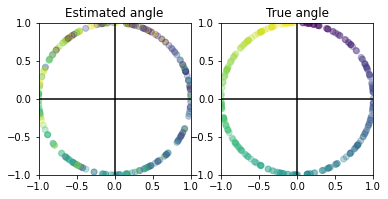

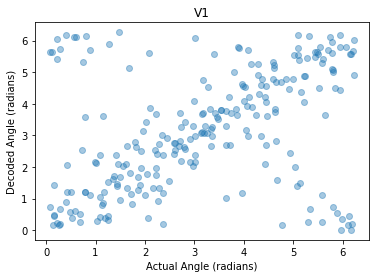

circular correlation == 0.403


In [68]:
# Plot true vs predicted angles
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(np.sin(y_hat), np.cos(y_hat), c=true_y, alpha=0.3)
ax.axhline(y = 0, color = 'k', linestyle = '-') 
ax.axvline(x = 0, color = 'k', linestyle = '-') 
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_aspect(1)
ax.set_title('Estimated angle')

ax = fig.add_subplot(122)
ax.scatter(np.sin(true_y), np.cos(true_y), c=true_y, alpha=0.3)
ax.axhline(y = 0, color = 'k', linestyle = '-') 
ax.axvline(x = 0, color = 'k', linestyle = '-') 
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_aspect(1)
ax.set_title('True angle')

plt.figure()
plt.scatter(true_y, y_hat, alpha = .4)
plt.title(roi)
plt.xlabel('Actual Angle (radians)')
plt.ylabel('Decoded Angle (radians)')
plt.show() 
print( f'circular correlation == {np.round(cc,3)}' )

## 04. Use MDS to visualize the geometry of target object's locations as represented in voxel activity 

<div class="alert alert-success"> <b>*** Tasks *** </b><br>
<b>(a). Change the number of sessions and the selected roi used for MDS analysis. How does having more / less data affect the geometry of neural representations? </b><br>
    <b>(b). Bonus: try running PCA instead of MDS. What do you see when projecting neural data onto low-D space? Compare and contrast the two methods. </b><br>


#### Bin the locations and then visualize the distance between pair-wise bins via MDS (serve as control)

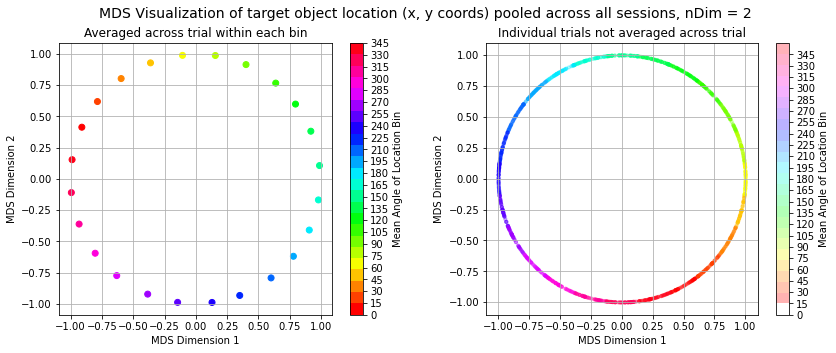

In [73]:
# Bin the location of target objects, we need x,y coordinates not angles for this analysis 
nbins = 24
loc_mat = {}

# Flatten out data (unwrap the session variable)
RunNum_allSess = np.concatenate(list(RunNum.values()),0)
StimLoc_allSess = np.concatenate(list(StimLoc.values()),0)

# For trials that fall into a particular bin, transform angles into X,Y coordinates centered on zero and store 
bins = np.digitize(StimLoc_allSess, np.arange(0,360,360/nbins)-7.5) 
for loc in range(1,nbins+1,1):
    loc_mat[str(loc-1)] = np.zeros([sum(bins==loc),2])
    trial_num = 0
    for trial in np.where(bins==loc)[0]: 
        rad = StimLoc_allSess[trial]*2*np.pi/360
        loc_mat[str(loc-1)][trial_num,:] = [np.cos(rad),np.sin(rad)]
        trial_num += 1

# Take the average within each bin to get mean location (lumping together all trials)
loc_mat_lumped = np.zeros((nbins,2))
for loc in range(nbins):
    loc_mat_lumped[loc,:] = np.zeros([2])
    loc_mat_lumped[loc,:] += np.mean(loc_mat[str(loc)],axis=0)
    
# Create an MDS model with the desired number of dimensions for visualization
ndim = 2 
mds = MDS(n_components=ndim)
 
# Fit the MDS model to (x,y) location of target object 
loc_reduced_lumped = mds.fit_transform(loc_mat_lumped)
loc_reduced = mds.fit_transform(np.concatenate(list(loc_mat.values()),0))
    
# Visualize the reduced data
fig, (ax1,ax2) = plt.subplots(figsize=(14, 5),ncols=2)
fig.suptitle(f'MDS Visualization of target object location (x, y coords) pooled across all sessions,'
            f' nDim = {ndim}', fontsize=14)
p1 = ax1.scatter(loc_reduced_lumped[:, 0], loc_reduced_lumped[:, 1], \
            c=range(nbins), cmap=plt.cm.get_cmap("hsv", nbins))
ax1.grid()
c1 = fig.colorbar(p1,ax=ax1,label='Mean Angle of Location Bin')
c1.set_ticks(ticks=range(nbins), labels=(np.arange(0,360,360/nbins)).astype(int))
ax1.set_title(f'Averaged across trial within each bin')
ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_aspect('equal')

p2 = ax2.scatter(loc_reduced[:, 0], loc_reduced[:, 1], \
            c=np.sort(bins), cmap=plt.cm.get_cmap("hsv", nbins),alpha=0.3,s=10)
ax2.grid()
c2 = fig.colorbar(p2,ax=ax2,label='Mean Angle of Location Bin')
c2.set_ticks(ticks=range(nbins), labels=(np.arange(0,360,360/nbins)).astype(int))
ax2.set_title(f'Individual trials not averaged across trial')
ax2.set_xlabel("MDS Dimension 1")
ax2.set_ylabel("MDS Dimension 2")
ax2.set_aspect('equal')


#### Bin the neural activity by target object's location and then visualize the distance between them via MDS 

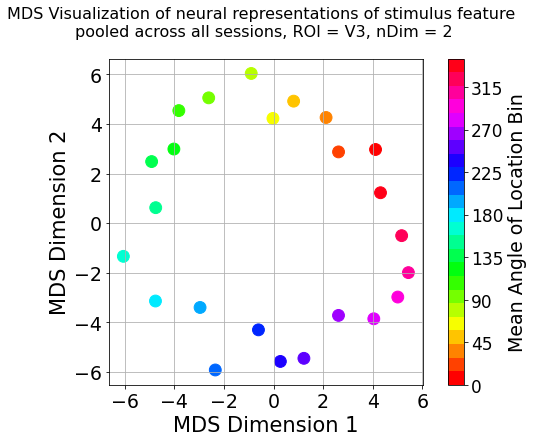

In [77]:
# (a). Test how the amount of data available affects the neural representations of stimulus location

# Select ROI of interest and define other variables

# —————————————————————————— change values ——————————————————————————
roi = 'V3'
sessions = ['01','02','03','04','05']
# ———————————————————————————————————————————————————————————————————
time_window = [6,9]

# Need to parse neural activity grouped by the trial's target object location bin  
neural_vec = {}
trial_cnt = {}

for sess in sessions:
    
    neural_vec[sess] = {}
    trial_cnt[sess] = {}
    bins = np.digitize(StimLoc[sess], np.arange(0,360,360/nbins)-7.5) 
    Dat = np.mean(VoxDat[sess][roi][:,time_window[0]:time_window[1],:],axis=1) 
    
    for loc in range(1,nbins+1,1):

        neural_vec[sess][str(loc-1)] = np.zeros([sum(bins==loc),Dat.shape[1]])
        trial_cnt[sess][str(loc-1)] = sum(bins==loc)
        
        trial_num = 0
        for trial in np.where(bins==loc)[0]:
            neural_vec[sess][str(loc-1)][trial_num,:] = Dat[trial]
            trial_num += 1
            
        neural_vec[sess][str(loc-1)] = np.mean(neural_vec[sess][str(loc-1)],axis=0)
        

# Bin neural activities by the location of target object on trial, take average to get a 'canonical'
# activity pattern for any given location bin.
neural_vec_allSess_lumped = np.zeros((nbins,Dat.shape[1]))
for loc in range(nbins):
    neural_vec_allSess_lumped[loc,:] = np.zeros([Dat.shape[1]])
    nTrial = 0
    for sess in sessions:
        neural_vec_allSess_lumped[loc,:] += neural_vec[sess][str(loc)]*trial_cnt[sess][str(loc)]
        nTrial += trial_cnt[sess][str(loc)]
    neural_vec_allSess_lumped[loc,:] /= nTrial


# Bin neural activities by the location of target object on trial, but no longer take average.
# Note that I'll make the bins start from 0 index
neural_vec_allSess = neural_vec['01']
stim_bin_allSess = np.digitize(StimLoc['01'], np.arange(0,360,360/nbins)-7.5)-1 
for sess in sessions:
    if sess=='01': 
        continue
    else:
        bins = np.digitize(StimLoc[sess], np.arange(0,360,360/nbins)-7.5)-1 
        neural_vec_allSess = np.vstack((neural_vec_allSess,neural_vec[sess]))
        stim_bin_allSess = np.hstack((stim_bin_allSess,bins))
        
# Create an MDS model with the desired number of dimensions for visualization
ndim = 2
mds = MDS(n_components=ndim)
 
# Fit the MDS model to neural representations of target object location
neural_vec_reduced_lumped = mds.fit_transform(neural_vec_allSess_lumped)

# Visualize the reduced data
fig, ax1 = plt.subplots(figsize=(9, 6),ncols=1)
fig.suptitle(f'MDS Visualization of neural representations of stimulus feature \npooled across all sessions,'
            f' ROI = {roi}, nDim = {ndim}', fontsize=16, y=1.001)
p1 = ax1.scatter(neural_vec_reduced_lumped[:, 0], neural_vec_reduced_lumped[:, 1], \
            c=range(nbins), cmap=plt.cm.get_cmap("hsv", nbins),s=140)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
ax1.grid()
c1 = fig.colorbar(p1,ax=ax1)
c1.set_label(label='Mean Angle of Location Bin',size=19)
c1.set_ticks(ticks=[0,3,6,9,12,15,18,21], labels=(np.arange(0,360,360/nbins*3)).astype(int),fontsize=17)
ax1.set_xlabel("MDS Dimension 1",fontsize=21)
ax1.set_ylabel("MDS Dimension 2",fontsize=21)
ax1.set_aspect('equal')
